# Business Data Analytics - Exercise Deep Learning

In this notebook, we will apply transfer learning on the [CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset. First, we will extract bottleneck features from the pretrained model and then, build our own model on top. The pretrained neural network we will work with is the [Inception-V3](https://arxiv.org/abs/1512.00567v3), but the general idea of this approach can be applied to any other pretrained neural network. The more similar the training data of the pretrained model to the training data of the task at hand, the better features can we extract from the pretrained model. In our case, the Inception-V3 model was trained on the [ImageNet](https://de.wikipedia.org/wiki/ImageNet), which is fairly similar.

### Import libraries

In [1]:
!pip install -r requirements.txt

You should consider upgrading via the 'c:\users\di872\desktop\lehre\bda\ss2022\übung\exercises\04_deep_learning\venv\scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
# data wrangling
import pandas as pd
import numpy as np
from PIL import Image

# visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning and deep learning
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import keras
from keras.datasets import cifar10
from keras.callbacks import ModelCheckpoint   
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.utils import np_utils

### Load and inspect the data

We will first load the data and, to make our lifes easier, limit the dataset size so that training our own neural network becomes feasible.

In [3]:
# load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data() 

In [4]:
# limit dataset size if you want to see quick results
x_train, y_train, x_test, y_test = x_train[:2500], y_train[:2500], x_test[:1000], y_test[:1000]

In [5]:
# inspect final shapes
print('x_train shape:\t', x_train.shape)
print('x_test shape:\t', x_test.shape)

x_train shape:	 (2500, 32, 32, 3)
x_test shape:	 (1000, 32, 32, 3)


In [6]:
# Plot an image for each class
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
num_classes = 10

#### Task: Plot an image of each class

Fill out this function to plot an image of each class

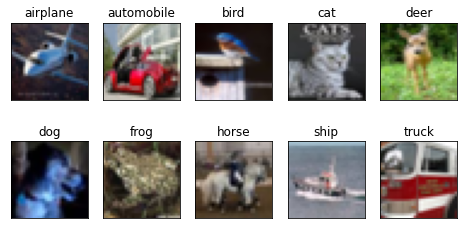

In [7]:
def plot_image_of_each_class():

    # Print figure with 10 random images from each
    fig = plt.figure(figsize=(8,4))
    for i in range(num_classes):
        ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
        idx = np.where(y_train[:]==i)[0]
        features_idx = x_train[idx,::]
        img_num = np.random.randint(features_idx.shape[0])
        ax.set_title(class_names[i])
        plt.imshow(features_idx[img_num,::])
    plt.show()
    
plot_image_of_each_class()

### Extract features from pretrained model

In [8]:
# load model
# it is recommended to use an image shape greater than (75, 75)
# we exclude the top layers so that we access the feature layers directly
model = InceptionV3(weights='imagenet', include_top=False, input_shape=(139, 139, 3))

In [9]:
# as we have seen earlier, the input shape of our images are not in the required shape. hence, we need to upscale them. 
# as a last step, we need to apply the same preprocessing steps that the images have undergone before they were fed 
# into the inception model for training
def preprocess_raw_image(x: np.ndarray) -> np.ndarray:
    
    # resize images and transform to array
    x_resized = np.array([np.array(Image.fromarray(x[i]).resize((139, 139))) for i in range(0, len(x))]).astype('float32')
    
    # further process data according to requirements of inceptionv3
    x_inception = preprocess_input(x_resized)
    
    return x_inception

In [10]:
# pre-process data for feature extraction
x_train = preprocess_raw_image(x_train)
x_test = preprocess_raw_image(x_test)

In [11]:
# check for shape
assert x_train.shape[1:] == (139, 139, 3), 'shape values of training data are not in the required form'
assert x_test.shape[1:] == (139, 139, 3), 'shape values of test data are not in the required form'

#### Task: Extract features from preprocessed images

Fill out the function to obtain the features from our pretrained model.

In [12]:
def get_bottle_neck_features(x: np.ndarray) -> np.ndarray:
    return model.predict(x)

In [13]:
# extract bottleneck features
# this might take a while
features_train = get_bottle_neck_features(x_train)
features_test = get_bottle_neck_features(x_test)

32/32 [==============================] - 18s 573ms/step


In [14]:
# one hot encode labels
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

### Train own neural network

Now it is time to define and train our very first neural network.

#### Task: Build a simple sequential neural network

As an inspiration, you can have a look at the following architecture:

<img src="cnn.png" align="left"/>

In [15]:
# define model
def simple_model(image_shape):
    
    model = Sequential()
    model.add(Conv2D(filters=100, kernel_size=2, input_shape=image_shape))
    model.add(Dropout(0.4))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.3))
    model.add(Dense(10, activation='softmax'))
    
    return model

simple_nn = simple_model(image_shape=features_train.shape[1:])

In [16]:
# inspect model architecture
print(simple_nn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 2, 2, 100)         819300    
                                                                 
 dropout (Dropout)           (None, 2, 2, 100)         0         
                                                                 
 global_average_pooling2d (G  (None, 100)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
Total params: 820,310
Trainable params: 820,310
Non-trainable params: 0
__________________________________________________

In [17]:
# compile model and choose optimizer, loss function and evaluation metric
simple_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# Declare variables
batch_size = 32  # the size the batch size, the more updates during an epoch
epochs = 10  # repeat n times

In [19]:
# Fit model
history = simple_nn.fit(features_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.25, shuffle=True)

Epoch 1/10
59/59 [==============================] - 2s 17ms/step - loss: 6.1038 - accuracy: 0.5792 - val_loss: 2.8340 - val_accuracy: 0.7664
Epoch 2/10
59/59 [==============================] - 1s 13ms/step - loss: 2.6734 - accuracy: 0.7781 - val_loss: 3.0730 - val_accuracy: 0.7696
Epoch 3/10
59/59 [==============================] - 1s 13ms/step - loss: 2.1110 - accuracy: 0.8043 - val_loss: 3.1611 - val_accuracy: 0.7680
Epoch 4/10
59/59 [==============================] - 1s 13ms/step - loss: 1.0609 - accuracy: 0.8752 - val_loss: 3.1573 - val_accuracy: 0.7776
Epoch 5/10
59/59 [==============================] - 1s 18ms/step - loss: 0.8436 - accuracy: 0.9029 - val_loss: 3.4552 - val_accuracy: 0.7664
Epoch 6/10
59/59 [==============================] - 1s 19ms/step - loss: 0.8723 - accuracy: 0.8981 - val_loss: 3.8737 - val_accuracy: 0.7584
Epoch 7/10
59/59 [==============================] - 1s 15ms/step - loss: 0.9592 - accuracy: 0.8949 - val_loss: 3.2844 - val_accuracy: 0.7984
Epoch 8/10
59

#### Task: Evaluate the learning progess of the model by plotting its loss 

You can use the history variable from above to get the loss and accuracy values.

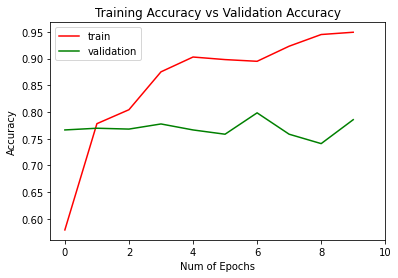

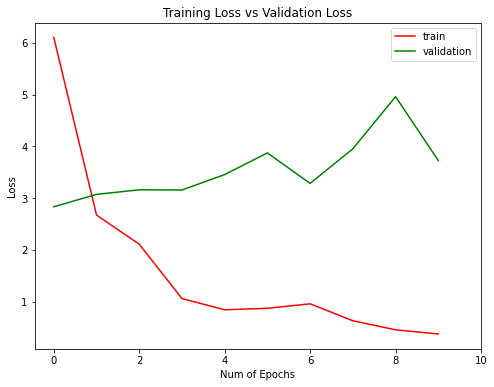

In [20]:
# Plots for training and testing process: loss and accuracy
plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, 11, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])

plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, 11, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
plt.show()

#### Task: Evaluate your model by calculating the accuracy and confusion matrix

Now it is time to test your model on the test data. Use the accuracy metric to get an overall picture of your model and the confusion matrix to dive deeper into your analysis. To plot the confusion matrix, checkout seaborn for a [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) that helps to visialize the predictions of our model. The confusion matrix itself and the accuracy can calculated with the help of [sklearn's metric functions](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

In [21]:
scores = simple_nn.evaluate(features_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 76.40%


32/32 - 0s - 154ms/epoch - 5ms/step


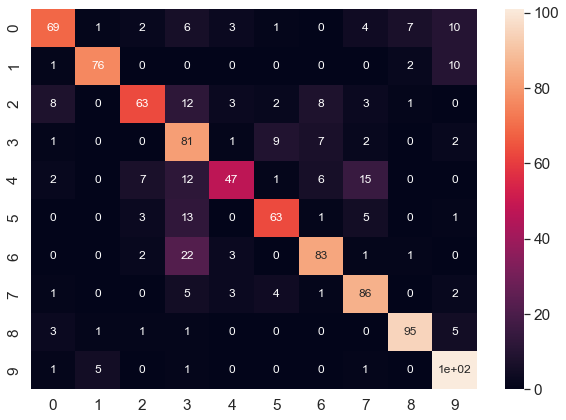

In [22]:
Y_pred = simple_nn.predict(features_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(np.argmax(y_test, axis=1),y_pred)

# Visualizing of confusion matrix
df_cm = pd.DataFrame(cm, range(10),range(10))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) #for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()